# Initial Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv")
df.head()

,ID,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,5,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,5,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,5,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,5,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,5,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Shuffling Values of All Non-Selected Features

## Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

Add a column for the calculated synthetic data

In [2]:
import random

# Function to calculate synthetic outcome values
def func_val_bin(predictors):
    """
        Creates a function out of five variables in the predictors dataframe
        and outputs a boolean Pandas series where True means the function value
        was greater than or equal to the median and False otherwise.

        Parameters:
            predictors (Dataframe): pandas Dataframe containing all predictor features

        Output:
            (Series): pandas Series containing True and False values where True means that
                      the calculated value was above the median and False otherwise
    """

    # Initialize array to store continuous values of function
    func_calcs = np.array([])

    # Get random coefficients and features
    random.seed(42)
    coefficients = np.array([round(random.uniform(-5, 5), 1) for _ in range(5)])
    selected_features = np.array(random.sample(list(predictors.columns), 5))

    print("Function = 1/(1+e^{-(" + 
            f"{coefficients[0]} * {selected_features[0]} + " +
            f"{coefficients[1]} * {selected_features[1]} + " +
            f"{coefficients[2]} * {selected_features[2]} + " +
            f"{coefficients[3]} * {selected_features[3]} + " +
            f"{coefficients[4]} * {selected_features[4]}" + 
            ")})")
    
    for index, row in predictors.iterrows():
        # Add new calculation to func_calcs
        func_calcs = np.append(func_calcs, 1/(1+np.e**(-(coefficients[0] * row[selected_features[0]] +
                                              coefficients[1] * row[selected_features[1]] +
                                              coefficients[2] * row[selected_features[2]] +
                                              coefficients[3] * row[selected_features[3]] +
                                              coefficients[4] * row[selected_features[4]]))))

    return pd.Series(data = (func_calcs >= 0.5).astype(int)), selected_features

In [3]:
# Create the outcome feature
synthetic_vals, selected_features = func_val_bin(df)
df["synthetic_outcome"] = synthetic_vals

Function = 1/(1+e^{-(1.4 * fNIRS_S8D6_hbr_timeToMax_version12 + -4.7 * fNIRS_S6D6_hbr_kurtosis_version17 + -2.2 * EEG_p100_poz_version11 + -2.8 * fNIRS_S7D5_hbo_kurtosis_version03 + 2.4 * fNIRS_S5D3_hbr_kurtosis_version11)})


In [4]:
predictors_df = df.iloc[:, 1:(df.shape[1] - 5)]
outcomes_df = df.iloc[:, (df.shape[1] - 5):]

# Randomize data in all non-selected feature columns
for col in predictors_df.columns:
    # Don't randomize selected features
    if col in selected_features:
        continue

    predictors_df[col] = np.random.permutation(predictors_df[col].values)

display(predictors_df)
display(outcomes_df)

# Split into train and test
predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

display(predictors_train)
display(outcomes_train)

# Scale the data
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
predictors_test = scaler.transform(predictors_test)
predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

display(predictors_train)

# Free up memory
del df
del predictors_df
del outcomes_df

,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,-0.320525,3.447829,-0.704162,-0.052621,0.204803,0.761195,3.447279,0.431375,0.000000,0.055425,...,-0.064239,0.126067,0.246068,0.259256,-1.179334,1.108622,-0.266532,-0.172166,0.637170,-0.406958
1,-0.620807,0.108571,0.644553,0.711197,-1.143716,1.105370,5.576809,-0.278585,-0.381270,-0.558388,...,0.125644,0.553828,-0.055151,1.682599,2.170514,2.716596,0.196207,-0.336609,0.419895,0.739755
2,-0.714415,-0.403908,-0.478244,-0.409288,-0.248912,0.559665,-1.131586,1.027405,0.603905,0.360187,...,0.309453,-0.479757,-0.418917,0.769802,-0.495493,0.819586,-0.832655,-1.042634,0.269036,0.698494
3,-0.312291,-0.355095,0.197474,-2.219966,0.414908,0.691593,-0.551155,-0.241204,-0.120968,-1.023674,...,-0.111386,1.018686,-0.768448,0.650895,-0.320605,-0.427370,-2.971263,-1.344882,1.201660,-1.309779
4,0.581154,-0.381095,0.411544,1.154769,-1.240624,-0.041039,1.214370,0.542192,-0.493256,-0.596055,...,-0.184739,0.947198,-0.749513,0.588270,0.094825,-0.663735,-1.230679,0.360461,0.523294,-0.291697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.103193,-0.076871,-0.385595,2.739124,-1.657081,0.000000,1.671440,0.000000,-0.679889,5.020698,...,0.832598,-1.421879,0.172395,-1.201797,-1.848760,0.060765,0.450827,2.189873,-2.008172,0.370404
300,-0.720222,-0.032484,0.708645,0.769935,0.296930,0.137379,-0.037451,-0.142881,0.000000,-0.139320,...,0.152102,1.255472,-0.555193,0.233826,2.436617,-1.649437,-0.787868,0.318748,-0.796321,-0.477352
301,-0.752910,-0.362019,0.044329,0.434921,-1.396764,-0.415992,2.018638,-0.547836,0.499421,-1.128980,...,-1.480677,1.791404,2.323490,-1.136134,0.261106,-0.294957,-0.566511,-1.160890,0.163293,-1.440341
302,-0.465714,-0.735187,-0.982640,0.740229,-0.344376,-2.210110,-0.683907,-0.899814,-0.558297,-0.567322,...,-1.971378,-0.550725,0.067899,-0.249387,-0.849135,-1.245770,0.420022,-0.678148,1.381828,-0.303485


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
0,0.119790,1.593122,-0.800726,0.350233,1
1,0.075246,-1.663383,0.859309,-0.262893,1
2,-1.072729,0.879836,-1.542415,-0.938513,1
3,-0.643181,-0.217332,0.945816,0.145041,1
4,-0.323098,0.712401,-1.473404,-0.642872,1
...,...,...,...,...,...
299,0.076099,1.105227,-0.609431,0.209332,0
300,-0.258249,-0.360422,0.778641,0.155357,1
301,0.110240,0.092504,0.945232,0.627581,1
302,-1.105639,0.426616,0.328063,-0.108335,1


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
269,-0.789734,-0.566526,0.109825,-0.506206,-0.197257,0.842311,-0.339775,0.197605,-1.006203,-0.501586,...,1.174838,1.018292,0.060181,-1.101042,0.620108,1.527067,-0.664651,-0.169305,-0.171997,-1.440045
211,-0.598078,0.094184,-0.073457,-1.059710,1.233320,-0.099982,-1.714762,0.465817,-0.511862,-0.519493,...,-0.548652,1.181846,1.656398,0.037628,0.568487,-0.431520,-0.576094,-0.345905,-0.301990,1.657923
197,0.319710,-0.618450,1.282761,-0.659256,0.721673,0.000000,0.341369,0.059879,-0.091546,0.069638,...,1.148794,-0.306810,0.062537,0.064411,0.007059,-1.336422,2.853685,-0.512149,-2.614365,-0.860509
75,-0.338342,2.554621,-0.307842,-0.056275,0.357777,0.469791,-0.258565,-0.089433,0.105818,-0.799764,...,0.304035,1.203823,-0.468755,0.324137,-0.565269,-1.320804,-0.796984,0.245281,-0.817618,-1.068994
177,-0.743637,0.552497,1.423084,0.009381,0.218692,3.514211,-0.754827,0.000000,0.115300,-0.555953,...,-1.288096,1.489270,0.123966,0.214784,-0.002149,-0.063372,0.173056,-0.581999,0.673157,0.254171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.000000,-0.346018,0.697155,0.545542,0.049048,0.119713,-0.584818,0.283305,-0.704285,-0.268734,...,-1.355148,1.355268,-0.883532,-0.506775,-0.379363,-0.494632,0.124392,-0.873139,-0.298577,1.176818
71,-0.796969,0.144016,-0.727197,1.552358,-0.307338,0.054983,-2.048963,-0.455249,1.068357,-0.284962,...,0.080990,0.194275,0.805271,0.293527,-0.511802,1.268327,0.689936,-2.470424,0.230648,-0.576952
106,-0.397200,2.852104,0.023416,0.450465,0.233301,3.522785,-0.197094,0.015811,-0.504183,-0.545149,...,0.432980,-0.667217,0.418165,-0.020682,0.475154,-0.336831,0.368635,0.297896,-1.538414,0.768717
270,-0.851257,-0.901833,0.000000,-0.339642,-0.004899,0.408027,0.817302,-0.087981,-0.115394,-0.715333,...,0.257777,-1.312263,-0.915717,1.379299,0.191171,2.607307,-0.037417,0.920577,1.139130,-0.573271


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
269,0.143670,1.101324,-0.822506,0.117187,1
211,-0.783965,-0.834554,0.116317,-0.677632,0
197,0.475912,-0.162414,1.180378,0.804260,1
75,-0.088596,0.229732,0.972713,0.618738,0
177,-1.146056,0.662741,-3.060939,-1.932524,0
...,...,...,...,...,...
188,1.116062,0.313836,0.270247,0.799881,0
71,-0.881938,0.311514,-0.739256,-0.666210,1
106,-0.900207,0.372292,-1.423042,-1.032613,0
270,-2.025591,0.753425,0.139548,-0.472791,1


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,-0.797036,-0.588659,0.157157,-0.508528,-0.197596,0.786607,-0.338071,0.141133,-0.957364,-0.502597,...,1.230320,0.992512,0.068778,-1.119762,0.600838,1.525718,-0.670571,-0.187794,-0.169433,-1.570568
1,-0.605902,0.056401,-0.029084,-1.056900,1.260602,-0.147575,-1.676056,0.391740,-0.497362,-0.519378,...,-0.648581,1.152726,1.600785,-0.025203,0.549140,-0.407958,-0.583667,-0.362974,-0.299139,1.714507
2,0.309386,-0.639354,1.349026,-0.660159,0.739077,-0.048454,0.324744,0.012448,-0.106243,0.032697,...,1.201927,-0.305531,0.071040,0.000542,-0.013120,-1.301350,2.782099,-0.527882,-2.606401,-0.956030
3,-0.346873,2.458558,-0.267252,-0.062768,0.368155,0.417293,-0.259046,-0.127064,0.077412,-0.782021,...,0.280994,1.174254,-0.438880,0.250207,-0.586296,-1.285930,-0.800434,0.223459,-0.813627,-1.177107
4,-0.751064,0.503858,1.491614,0.002280,0.226384,3.435505,-0.741954,-0.043501,0.086235,-0.553544,...,-1.454702,1.453872,0.129997,0.145090,-0.022342,-0.044492,0.151501,-0.597170,0.673852,0.225974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,-0.009453,-0.373374,0.753967,0.533471,0.053465,0.070229,-0.576520,0.221208,-0.676419,-0.284391,...,-1.527801,1.322606,-0.836972,-0.548516,-0.400114,-0.470267,0.103745,-0.885969,-0.295734,1.204345
239,-0.804251,0.105052,-0.693376,1.530954,-0.309802,0.006056,-2.001263,-0.468869,0.973089,-0.299599,...,0.037836,0.185321,0.783896,0.220783,-0.532749,1.270270,0.658734,-2.470410,0.232322,-0.655347
240,-0.405572,2.748995,0.069353,0.439276,0.241275,3.444006,-0.199229,-0.028728,-0.490216,-0.543420,...,0.421567,-0.658579,0.412362,-0.081254,0.455668,-0.314473,0.343429,0.275650,-1.532829,0.771596
241,-0.858391,-0.916024,0.045559,-0.343508,-0.001523,0.356061,0.787868,-0.125707,-0.128434,-0.702900,...,0.230564,-1.290453,-0.867862,1.264494,0.171264,2.592219,-0.055043,0.893324,1.138795,-0.651444


## Hyperparameter Selection

In [5]:
def select_hyperparameters(model, predictors, outcome, params, eval_metric):
    """
        Conducts GridSearchCV on a Logistic Regression model to identify suitable hyperparameters

        Parameters:
            model (sklearn Model): sklearn Model to conduct GridSearchCV on
            predictors (Dataframe): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            params (dictionary): Dictionary of parameters for GridSearchCV for a LogisticRegression model
            eval_metric (string): Name of evaluation metric to use for GridSearchCV

        Return:
            clf (GridSearchCV): GridSearchCV object after running GridSearchCV with provided parameters
    """
    
    # Perform 5-fold cross-validation with different regularization strengths and regularization types
    clf = GridSearchCV(model, params, cv = 5, scoring = eval_metric, n_jobs = -1)
    clf.fit(predictors, outcome)

    # Show the best regularization strength and penaalty type
    print("Best regularization strength:", clf.best_params_["C"])
    print("Best l1_ratio:", clf.best_params_["l1_ratio"])

    return clf

In [6]:
params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.1, 0.5, 0.9, 1]
}

SA_func_Log_Reg = LogisticRegression(solver = "saga", penalty = "elasticnet", max_iter = 10000, fit_intercept = False)
SA_GridSearchCV_func = select_hyperparameters(SA_func_Log_Reg, predictors_train, outcomes_train["synthetic_outcome"], params, "accuracy")

Best regularization strength: 0.1
Best l1_ratio: 1


In [8]:
print(np.sum(SA_GridSearchCV_func.best_estimator_.coef_ != 0))
print(SA_GridSearchCV_func.best_score_)

67
0.8354591836734695


## Fit Actual Model with Training Data

In [5]:
SA_model_func = LogisticRegression(max_iter = 15000, penalty = "elasticnet", solver = "saga", C = 0.1, l1_ratio = 1, n_jobs = -1, fit_intercept = False)
SA_model_func.fit(predictors_train, outcomes_train["synthetic_outcome"])
SA_model_func

LogisticRegression(C=0.1, fit_intercept=False, l1_ratio=1, max_iter=15000,
                   n_jobs=-1, penalty='elasticnet', solver='saga')

In [18]:
np.sum(SA_model_func.coef_ != 0)

np.int64(65)

In [7]:
SA_model_func_coef = pd.DataFrame(
    data = {
        "coefficients": SA_model_func.coef_[0]
    },
    index = np.array(list(predictors_test.columns))
)

display(SA_model_func_coef.loc[selected_features, :])
display(SA_model_func_coef[SA_model_func_coef["coefficients"] != 0])

,coefficients
fNIRS_S8D6_hbr_timeToMax_version12,0.126171
fNIRS_S6D6_hbr_kurtosis_version17,-1.516998
EEG_p100_poz_version11,0.000000
fNIRS_S7D5_hbo_kurtosis_version03,-1.039624
fNIRS_S5D3_hbr_kurtosis_version11,0.102187


,coefficients
EDA_TonicMin_version23,-0.000518
EYE_corm_version19,-0.020965
EYE_det_version22,0.000511
EEG_avgRelMedAlpha_version10,0.094045
EEG_avgRelFroBeta_version16,-0.046890
...,...
fNIRS_S8D6_hbr_RMS_version23,-0.005556
fNIRS_S8D6_hbr_timeToMax_version12,0.126171
fNIRS_S8D6_hbr_timeToMax_version17,0.052640
fNIRS_S8D7_hbo_skew_version05,-0.035306


## Evaluate Model Performance

In [8]:
def get_eval_metrics(model, predictors, outcome):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  0.9508196721311475


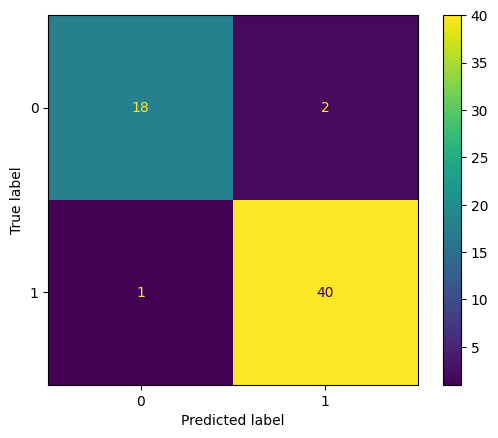

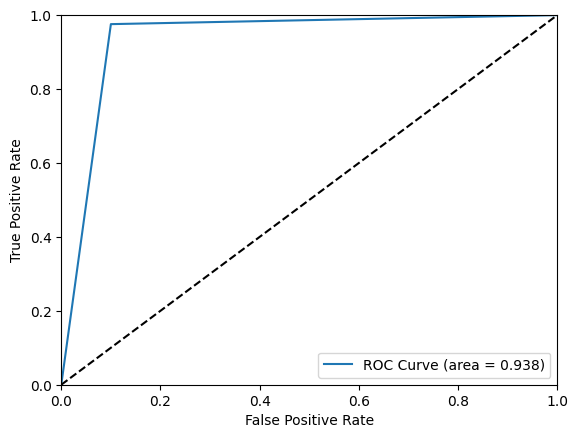

In [9]:
get_eval_metrics(SA_model_func, predictors_test, outcomes_test["synthetic_outcome"])

# Shuffling Outcome Values

## Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

Add a column for the calculated synthetic data

In [12]:
import random

# Function to calculate synthetic outcome values
def func_val_bin(predictors):
    """
        Creates a function out of five variables in the predictors dataframe
        and outputs a boolean Pandas series where True means the function value
        was greater than or equal to the median and False otherwise.

        Parameters:
            predictors (Dataframe): pandas Dataframe containing all predictor features

        Output:
            (Series): pandas Series containing True and False values where True means that
                      the calculated value was above the median and False otherwise
    """

    # Initialize array to store continuous values of function
    func_calcs = np.array([])

    # Get random coefficients and features
    random.seed(42)
    coefficients = np.array([round(random.uniform(-5, 5), 1) for _ in range(5)])
    selected_features = np.array(random.sample(list(predictors.columns), 5))

    print("Function = 1/(1+e^{-(" + 
            f"{coefficients[0]} * {selected_features[0]} + " +
            f"{coefficients[1]} * {selected_features[1]} + " +
            f"{coefficients[2]} * {selected_features[2]} + " +
            f"{coefficients[3]} * {selected_features[3]} + " +
            f"{coefficients[4]} * {selected_features[4]}" + 
            ")})")
    
    for index, row in predictors.iterrows():
        # Add new calculation to func_calcs
        func_calcs = np.append(func_calcs, 1/(1+np.e**(-(coefficients[0] * row[selected_features[0]] +
                                              coefficients[1] * row[selected_features[1]] +
                                              coefficients[2] * row[selected_features[2]] +
                                              coefficients[3] * row[selected_features[3]] +
                                              coefficients[4] * row[selected_features[4]]))))

    return pd.Series(data = (func_calcs >= 0.5).astype(int)), selected_features

In [13]:
# Create the outcome feature
synthetic_vals, selected_features = func_val_bin(df)
df["synthetic_outcome"] = synthetic_vals

Function = 1/(1+e^{-(1.4 * fNIRS_S8D6_hbr_timeToMax_version12 + -4.7 * fNIRS_S6D6_hbr_kurtosis_version17 + -2.2 * EEG_p100_poz_version11 + -2.8 * fNIRS_S7D5_hbo_kurtosis_version03 + 2.4 * fNIRS_S5D3_hbr_kurtosis_version11)})


In [14]:
predictors_df = df.iloc[:, 1:(df.shape[1] - 5)]
outcomes_df = df.iloc[:, (df.shape[1] - 5):]

# Randomize labels in outcome variable
outcomes_df["synthetic_outcome"] = np.random.permutation(outcomes_df["synthetic_outcome"].values)

display(predictors_df)
display(outcomes_df)

# Split into train and test
predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

display(predictors_train)
display(outcomes_train)

# Scale the data
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
predictors_test = scaler.transform(predictors_test)
predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

display(predictors_train)

# Free up memory
del df
del predictors_df
del outcomes_df

,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,-0.469374,...,-2.470055,-1.633813,-1.521523,-1.189742,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156
1,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,-0.160570,...,-1.999027,-1.796969,-0.890211,-0.846923,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842
2,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,-0.390771,...,-1.722859,-1.645669,-0.543299,-0.588502,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338
3,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,-0.440284,...,-1.460630,-0.940319,-0.955926,-0.744128,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023
4,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,-0.640221,...,-1.634937,-0.156605,-0.344389,0.214848,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,-0.390463,-0.392143,-0.150550,-0.112208,-0.248912,-0.241573,-0.239724,-0.191818,-0.336535,-0.330997,...,-0.046622,-0.464843,0.523703,0.110708,0.163210,-0.308442,0.105745,-0.391989,0.798338,-0.432294
300,-0.369596,-0.380586,-0.609280,-0.487820,-0.175647,-0.203160,-0.582746,-0.450147,-0.286580,-0.305082,...,-0.102853,-0.200243,0.539456,0.390624,0.101655,-0.000704,0.021136,-0.062902,0.571962,0.092100
301,-0.457362,-0.382835,-1.247644,-0.132967,-0.483803,-0.210636,-1.131586,-0.204537,-0.496694,-0.310125,...,0.160880,-0.095837,2.240786,1.697116,0.390354,0.120724,0.417964,0.066950,1.633695,0.299016
302,-0.370669,-0.390531,-1.078873,-0.866528,-0.179415,-0.236215,-0.917973,-0.699119,-0.289149,-0.327382,...,-0.394919,-0.514674,-0.292277,-0.368327,-0.218058,-0.366396,-0.418322,-0.453964,-0.603831,-0.531050


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
0,0.119790,1.593122,-0.800726,0.350233,0
1,0.075246,-1.663383,0.859309,-0.262893,1
2,-1.072729,0.879836,-1.542415,-0.938513,1
3,-0.643181,-0.217332,0.945816,0.145041,1
4,-0.323098,0.712401,-1.473404,-0.642872,1
...,...,...,...,...,...
299,0.076099,1.105227,-0.609431,0.209332,1
300,-0.258249,-0.360422,0.778641,0.155357,1
301,0.110240,0.092504,0.945232,0.627581,1
302,-1.105639,0.426616,0.328063,-0.108335,0


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
269,-0.494618,-0.555541,-2.076390,-1.869410,0.597167,0.362062,-1.765695,-1.479098,0.418093,0.161042,...,0.462172,0.859784,-0.051114,0.233826,0.237753,0.649436,0.111443,0.465456,0.779651,0.627392
211,-0.495506,-0.500435,-0.131699,-0.129467,-0.662698,-0.644065,-0.258565,-0.237457,-0.612173,-0.596055,...,-0.260123,1.010109,-0.213657,0.601153,-0.307295,0.907735,-0.047399,1.014504,0.237016,1.841947
197,0.297909,0.310984,-1.254804,-0.683124,-0.014281,0.030278,-0.612785,-0.323310,-0.147675,-0.124319,...,-1.458536,-2.291505,-0.823308,-1.187300,-1.355405,-1.868532,-0.703187,-1.310684,-0.785986,-1.462410
75,-0.751382,-0.767114,0.220138,-0.002063,-1.119621,-1.112651,0.082926,-0.217642,-1.034901,-1.023674,...,-0.084950,-0.236394,-1.212890,-1.107865,-0.042654,-0.178245,-0.830580,-0.678148,-1.206773,-0.626839
177,-0.354384,-0.332566,-1.195093,-0.569050,-1.246429,-1.107403,-0.981167,-0.478398,-0.795857,-0.715333,...,0.509455,0.654922,0.548907,0.656188,0.507635,0.712548,-0.440298,0.200804,-0.601341,0.526651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-0.297054,-0.307219,-0.661230,-0.513394,-1.014946,-0.994582,-0.575531,-0.431628,-0.679828,-0.661295,...,-0.726769,-1.195044,-0.629046,-0.860808,-0.798998,-1.181357,0.012439,-0.598611,0.566104,-0.681974
71,-0.559570,-0.562361,1.381119,0.854606,-0.446144,-0.432101,1.443925,0.759285,-0.517737,-0.506605,...,0.597457,0.281063,-0.908693,-0.867127,0.619710,0.355382,0.196207,-0.034579,0.716476,0.070465
106,-0.362930,-0.376268,-0.392341,-0.370327,-0.500164,-0.518055,-0.417380,-0.369009,-0.471410,-0.478937,...,1.048729,1.497494,-0.488310,-0.037478,1.458071,2.088352,-0.736493,0.362864,-1.311561,0.741032
270,-0.663595,-0.680655,-0.323792,-0.360686,0.003870,-0.053789,-0.548041,-0.547836,-0.197162,-0.265638,...,0.846641,1.038962,0.487292,0.634474,0.559359,0.808679,0.689936,0.688303,2.265877,0.874194


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
269,0.143670,1.101324,-0.822506,0.117187,0
211,-0.783965,-0.834554,0.116317,-0.677632,1
197,0.475912,-0.162414,1.180378,0.804260,0
75,-0.088596,0.229732,0.972713,0.618738,1
177,-1.146056,0.662741,-3.060939,-1.932524,0
...,...,...,...,...,...
188,1.116062,0.313836,0.270247,0.799881,0
71,-0.881938,0.311514,-0.739256,-0.666210,0
106,-0.900207,0.372292,-1.423042,-1.032613,0
270,-2.025591,0.753425,0.139548,-0.472791,1


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,-0.498774,-0.560976,-2.050127,-1.854451,0.577210,0.339142,-1.697864,-1.405132,0.394787,0.143846,...,0.454675,0.827464,-0.030701,0.300150,0.224543,0.608457,0.108515,0.414417,0.830405,0.605829
1,-0.499679,-0.504911,-0.144123,-0.145626,-0.690567,-0.675169,-0.258050,-0.237600,-0.613827,-0.600710,...,-0.263765,0.979137,-0.216744,0.755464,-0.320508,0.866908,-0.045040,0.958251,0.276126,1.835104
2,0.308872,0.320641,-1.244885,-0.689381,-0.038077,0.004659,-0.596449,-0.318328,-0.159091,-0.136788,...,-1.455783,-2.352085,-0.914538,-1.461383,-1.368624,-1.910998,-0.678999,-1.344857,-0.768828,-1.509301
3,-0.760436,-0.776234,0.200714,-0.020500,-1.150359,-1.147566,0.068188,-0.218968,-1.027671,-1.021246,...,-0.089527,-0.278544,-1.360446,-1.362921,-0.055866,-0.219713,-0.802152,-0.718327,-1.198644,-0.663603
4,-0.355864,-0.334118,-1.186363,-0.577347,-1.277963,-1.142275,-0.948377,-0.464160,-0.793650,-0.718012,...,0.501706,0.620765,0.656070,0.823681,0.494427,0.671606,-0.424861,0.152278,-0.580220,0.503866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,-0.297441,-0.308329,-0.663120,-0.522686,-1.045026,-1.028537,-0.560859,-0.420182,-0.680061,-0.664869,...,-0.727921,-1.245791,-0.692190,-1.056685,-0.812214,-1.223418,0.012807,-0.639546,0.612276,-0.719407
239,-0.564964,-0.567915,1.338598,0.820848,-0.472653,-0.461481,1.368398,0.699650,-0.521375,-0.512742,...,0.589238,0.243553,-1.012268,-1.064518,0.606502,0.314229,0.190458,-0.080869,0.765875,0.042152
240,-0.364573,-0.378581,-0.399581,-0.382179,-0.527012,-0.548134,-0.409772,-0.361300,-0.476023,-0.485532,...,1.038101,1.470893,-0.531106,-0.036140,1.444868,2.048222,-0.711197,0.312800,-1.305680,0.720846
241,-0.670974,-0.688270,-0.332395,-0.372710,-0.019813,-0.080091,-0.534597,-0.529454,-0.207538,-0.275766,...,0.837092,1.008249,0.585547,0.796767,0.546151,0.767793,0.667753,0.635148,2.348523,0.855622


## Hyperparameter Selection

In [15]:
def select_hyperparameters(model, predictors, outcome, params, eval_metric):
    """
        Conducts GridSearchCV on a Logistic Regression model to identify suitable hyperparameters

        Parameters:
            model (sklearn Model): sklearn Model to conduct GridSearchCV on
            predictors (Dataframe): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            params (dictionary): Dictionary of parameters for GridSearchCV for a LogisticRegression model
            eval_metric (string): Name of evaluation metric to use for GridSearchCV

        Return:
            clf (GridSearchCV): GridSearchCV object after running GridSearchCV with provided parameters
    """
    
    # Perform 5-fold cross-validation with different regularization strengths and regularization types
    clf = GridSearchCV(model, params, cv = 5, scoring = eval_metric, n_jobs = -1)
    clf.fit(predictors, outcome)

    # Show the best regularization strength and penaalty type
    print("Best regularization strength:", clf.best_params_["C"])
    print("Best l1_ratio:", clf.best_params_["l1_ratio"])

    return clf

In [16]:
params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.1, 0.5, 0.9, 1]
}

SA_func_Log_Reg = LogisticRegression(solver = "saga", penalty = "elasticnet", max_iter = 10000, fit_intercept = False)
SA_GridSearchCV_func = select_hyperparameters(SA_func_Log_Reg, predictors_train, outcomes_train["synthetic_outcome"], params, "accuracy")

Best regularization strength: 0.1
Best l1_ratio: 0.9


In [17]:
print(SA_GridSearchCV_func.best_score_)

127
0.48605442176870745


## Fit Actual Model with Training Data

In [19]:
SA_model_func = LogisticRegression(max_iter = 15000, penalty = "elasticnet", solver = "saga", C = 0.1, l1_ratio = 0.9, n_jobs = -1, fit_intercept = False)
SA_model_func.fit(predictors_train, outcomes_train["synthetic_outcome"])
SA_model_func

LogisticRegression(C=0.1, fit_intercept=False, l1_ratio=0.9, max_iter=15000,
                   n_jobs=-1, penalty='elasticnet', solver='saga')

## Evaluate Model Performance

In [22]:
def get_eval_metrics(model, predictors, outcome):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  0.5573770491803278


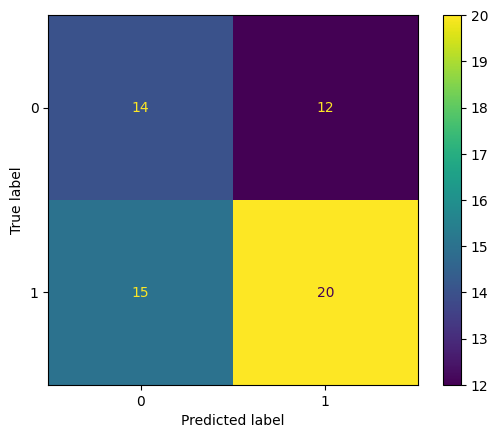

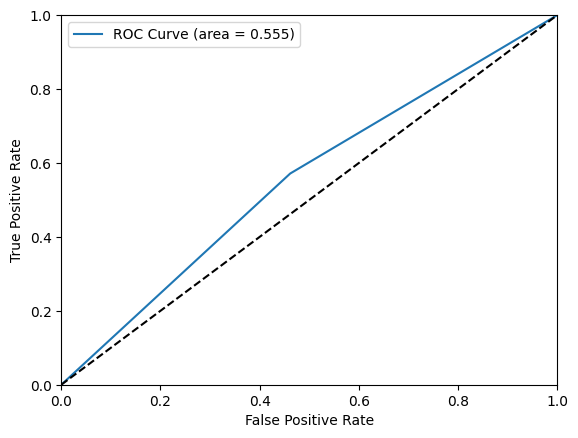

In [23]:
get_eval_metrics(SA_model_func, predictors_test, outcomes_test["synthetic_outcome"])